In [25]:
# Install pycocotools package
import os
!mkdir /kaggle/working/packages
!cp -r /kaggle/input/pycocotools/* /kaggle/working/packages
os.chdir("/kaggle/working/packages/pycocotools-2.0.6/")
!python setup.py install
!pip install -q . --no-index --find-links /kaggle/working/packages/
os.chdir("/kaggle/working")

mkdir: cannot create directory ‘/kaggle/working/packages’: File exists
running install
/opt/conda/lib/python3.10/site-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/setuptools/command/easy_install.py:156: EasyInstallDeprecationWarning: easy_install command is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
running bdist_egg
running egg_info
writing pycocotools.egg-info/PKG-INFO
writing dependency_links to pycocotools.egg-info/dependency_links.txt
writing requirements to pycocotools.egg-info/requires.txt
writing top-level names to pycocotools.egg-info/top_level.txt
reading manifest file 'pycocotools.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'pycocotools.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
r

In [26]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Add segment anything from kaggle models 
### on the right hand side of the screen

In [27]:
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry


In [28]:
sam = sam_model_registry["vit_h"](checkpoint="/kaggle/input/segment-anything/pytorch/vit-h/1/model.pth")
#predictor = SamPredictor(sam)

In [29]:
mask_generator = SamAutomaticMaskGenerator(sam)

## Change to cuda or will be very slow

In [30]:
device = "cuda"
sam.to(device=device)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [31]:
import base64
import numpy as np
from pycocotools import _mask as coco_mask
import typing as t
import zlib

def encode_binary_mask(mask: np.ndarray) -> t.Text:
    """Converts a binary mask into OID challenge encoding ascii text."""

    # check input mask --
    if mask.dtype != bool:
        raise ValueError(
            "encode_binary_mask expects a binary mask, received dtype == %s" %
            mask.dtype)

    mask = np.squeeze(mask)
    if len(mask.shape) != 2:
        raise ValueError(
            "encode_binary_mask expects a 2d mask, received shape == %s" %
            mask.shape)

    # convert input mask to expected COCO API input --
    mask_to_encode = mask.reshape(mask.shape[0], mask.shape[1], 1)
    mask_to_encode = mask_to_encode.astype(np.uint8)
    mask_to_encode = np.asfortranarray(mask_to_encode)

    # RLE encode mask --
    encoded_mask = coco_mask.encode(mask_to_encode)[0]["counts"]

    # compress and base64 encoding --
    binary_str = zlib.compress(encoded_mask, zlib.Z_BEST_COMPRESSION)
    base64_str = base64.b64encode(binary_str)
    return base64_str



## Create Full path to test images

In [32]:
test_path = "/kaggle/input/ttttttttttt/T/"
test_images = os.listdir(test_path)
test_paths = [test_path + i for i in test_images]

## Check path is correct

In [33]:
test_paths

['/kaggle/input/ttttttttttt/T/T_R051_Taourirt_B02_B03_B04_B08_3.jpg',
 '/kaggle/input/ttttttttttt/T/T_R051_Taourirt_B02_B03_B04_B08_4.jpg']

## Read in the first (and only? test image)

In [36]:
tiff_data = cv2.imread(test_paths[1], cv2.IMREAD_UNCHANGED)



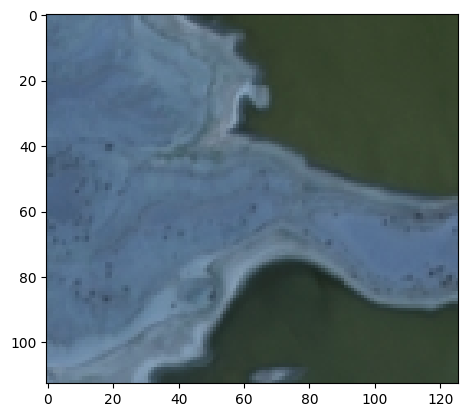

In [37]:
plt.imshow(tiff_data)

In [38]:
masks = mask_generator.generate(tiff_data)

In [40]:
def show_anns(anns):
    ## From the segment anything nb 
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))

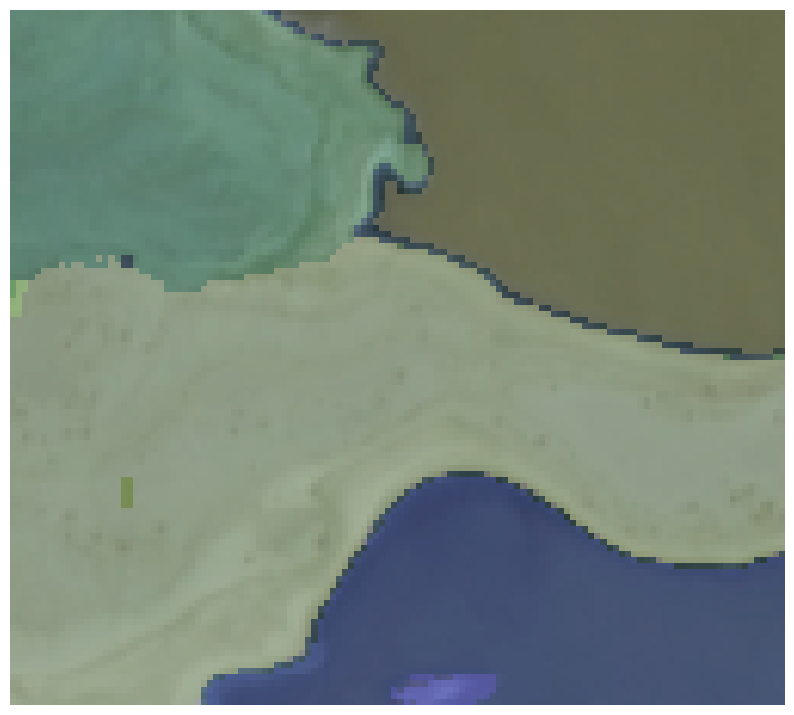

In [41]:
plt.figure(figsize=(10,10))
plt.imshow(tiff_data)
show_anns(masks)
plt.axis('off')
plt.show() 

## Take a look at the masks generated 


In [42]:
sorted_anns = sorted(masks, key=(lambda x: x['area']), reverse=True)
pd.DataFrame(sorted_anns).head()


,segmentation,area,bbox,predicted_iou,point_coords,stability_score,crop_box
0,"[[True, True, True, True, True, True, True, Tr...",8598,"[0, 0, 125, 112]",1.016947,"[[76.78125, 51.203125]]",0.986488,"[0, 0, 126, 113]"
1,"[[False, False, False, False, False, False, Fa...",6126,"[0, 37, 125, 75]",0.982993,"[[124.03125, 65.328125]]",0.958680,"[0, 0, 126, 113]"
2,"[[False, False, False, False, False, False, Fa...",3142,"[44, 0, 81, 55]",1.019994,"[[112.21875, 54.734375]]",0.956332,"[0, 0, 126, 113]"
3,"[[False, False, False, False, False, False, Fa...",2209,"[32, 76, 93, 36]",0.992502,"[[49.21875, 107.703125]]",0.953405,"[0, 0, 126, 113]"
4,"[[False, False, False, False, False, False, Fa...",76,"[62, 108, 16, 4]",0.978052,"[[68.90625, 111.234375]]",0.961538,"[0, 0, 126, 113]"


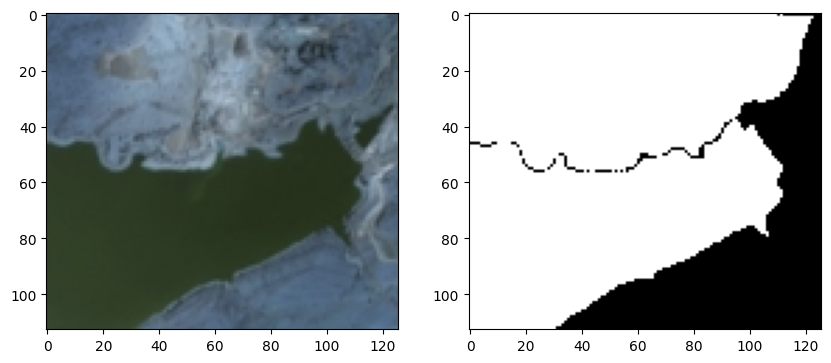

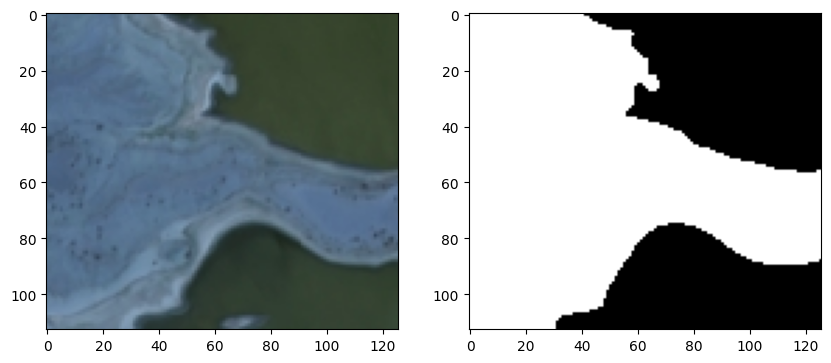

In [50]:

sample_submission = pd.read_csv('/kaggle/input/hubmap-hacking-the-human-vasculature/sample_submission.csv')

ids = []
heights = []
widths = []
prediction_strings = []
for img_name in os.listdir(test_path):
    img = cv2.imread(f"{test_path}/{img_name}")
    h, w, c = img.shape
    
    # Generate new mask for each image
    masks = mask_generator.generate(img)
    # after seg infer
    pred_string = ""
    fig, ax = plt.subplots(1,2, figsize = (10,10))
    ax[0].imshow(img)
    binmask = np.zeros((113,126), np.bool8)

    for i, item in enumerate(masks):
        if item['area'] > 200_000 or item['area'] < 4000:
            # Remove mask areas above or below a certain threshold
            continue
        temp = item['segmentation']
        # Combine the masks
        binmask = np.logical_or(binmask,temp)
        
        ax[1].imshow(binmask, cmap='gray', vmin=0, vmax=1)
        encoded = encode_binary_mask(binmask)
        # this below needs fixing
        if i == 0:
            pred_string += f"0 1.0 {encoded.decode('utf-8')}"
        else:
            pred_string += f" 0 1.0 {encoded.decode('utf-8')}"
    ids.append(img_name.split('.')[0])
    heights.append(h)
    widths.append(w)
    prediction_strings.append(pred_string)

plt.show()

In [51]:
# submission = pd.DataFrame()
# submission['id'] = ids
# submission['height'] = heights
# submission['width'] = widths
# submission['prediction_string'] = prediction_strings
# submission = submission.set_index('id')
# submission.to_csv("submission.csv")
# print(submission)

In [57]:
rm -rf /kaggle/working/packages